# Master 2 MAS - Projet Final Machine Learning
## Prédiction du prix des logements en Inde

**Étudiant :** Ayoub ACHOUR  
**Date :** Lundi 16 février 2026

### Reproductibilité
Ce notebook est conçu pour être exécuté en une seule fois via **Kernel -> Restart & Run All**.

- Aucune étape manuelle cachée.
- Toutes les graines aléatoires sont fixées.
- Les chemins de fichiers sont relatifs au dossier du projet.

## Plan du notebook
1. Description des objectifs et des données
2. Exploration et analyse descriptive
3. Séparation des données
4. Modélisation et sélection des hyperparamètres (cross-validation)
5. Évaluation finale et discussion critique

In [1]:
# =========================
# 0) Imports et configuration
# =========================
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    make_scorer,
)
from sklearn.model_selection import (
    train_test_split,
    KFold,
    RepeatedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (9, 5)


## 1) Description des objectifs et des données

### Objectif
Construire un modèle de **régression** capable de prédire `TARGET(PRICE_IN_LACS)` (prix en lakhs) à partir des caractéristiques d'un bien immobilier.

### Source des données
Les fichiers `train.csv`, `test.csv` et `sample_submission.csv` proviennent du challenge :
- **MachineHack - House Price Prediction Challenge**  
  https://www.kaggle.com/datasets/anmolkumar/house-price-prediction-challenge

### Variables principales
- Variables numériques/binaire : `UNDER_CONSTRUCTION`, `RERA`, `BHK_NO.`, `SQUARE_FT`, `READY_TO_MOVE`, `RESALE`, `LONGITUDE`, `LATITUDE`
- Variables catégorielles : `POSTED_BY`, `BHK_OR_RK`, `ADDRESS`
- Cible : `TARGET(PRICE_IN_LACS)`

In [2]:
# =========================
# 1) Chargement des données
# =========================
TRAIN_PATH = "archive/train.csv"
TEST_PATH = "archive/test.csv"

train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

print("train shape:", train_df.shape)
print("test shape :", test_df.shape)
print("Colonnes train:")
print(train_df.columns.tolist())

train shape: (29451, 12)
test shape : (68720, 11)
Colonnes train:
['POSTED_BY', 'UNDER_CONSTRUCTION', 'RERA', 'BHK_NO.', 'BHK_OR_RK', 'SQUARE_FT', 'READY_TO_MOVE', 'RESALE', 'ADDRESS', 'LONGITUDE', 'LATITUDE', 'TARGET(PRICE_IN_LACS)']


In [3]:
# Aperçu rapide
train_df.head()

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5


In [4]:
# Vérification des types et valeurs manquantes
display(train_df.info())
missing_ratio = (train_df.isna().mean().sort_values(ascending=False) * 100).round(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29451 entries, 0 to 29450
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   POSTED_BY              29451 non-null  object 
 1   UNDER_CONSTRUCTION     29451 non-null  int64  
 2   RERA                   29451 non-null  int64  
 3   BHK_NO.                29451 non-null  int64  
 4   BHK_OR_RK              29451 non-null  object 
 5   SQUARE_FT              29451 non-null  float64
 6   READY_TO_MOVE          29451 non-null  int64  
 7   RESALE                 29451 non-null  int64  
 8   ADDRESS                29451 non-null  object 
 9   LONGITUDE              29451 non-null  float64
 10  LATITUDE               29451 non-null  float64
 11  TARGET(PRICE_IN_LACS)  29451 non-null  float64
dtypes: float64(4), int64(5), object(3)
memory usage: 2.7+ MB


None

## 2) Exploration et analyse descriptive

Cette section vise à :
- comprendre la distribution de la cible,
- identifier des relations utiles entre variables et cible,
- préparer des choix de modélisation robustes (prétraitement, métriques, CV).

In [5]:
# Statistiques descriptives de base
train_df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
POSTED_BY,29451,3,Dealer,18291,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UNDER_CONSTRUCTION,29451.0,NaN,NaN,NaN,0.179756,0.383991,0.0,0.0,0.0,0.0,1.0
RERA,29451.0,NaN,NaN,NaN,0.317918,0.465675,0.0,0.0,0.0,1.0,1.0
BHK_NO.,29451.0,NaN,NaN,NaN,2.392279,0.879091,1.0,2.0,2.0,3.0,20.0
BHK_OR_RK,29451,2,BHK,29427,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SQUARE_FT,29451.0,NaN,NaN,NaN,19802.17019,1901334.912504,3.0,900.02113,1175.05675,1550.688124,254545454.5
READY_TO_MOVE,29451.0,NaN,NaN,NaN,0.820244,0.383991,0.0,1.0,1.0,1.0,1.0
RESALE,29451.0,NaN,NaN,NaN,0.929578,0.255861,0.0,1.0,1.0,1.0,1.0
ADDRESS,29451,6899,"Zirakpur,Chandigarh",509,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LONGITUDE,29451.0,NaN,NaN,NaN,21.300255,6.205306,-37.713008,18.452663,20.75,26.900926,59.912884


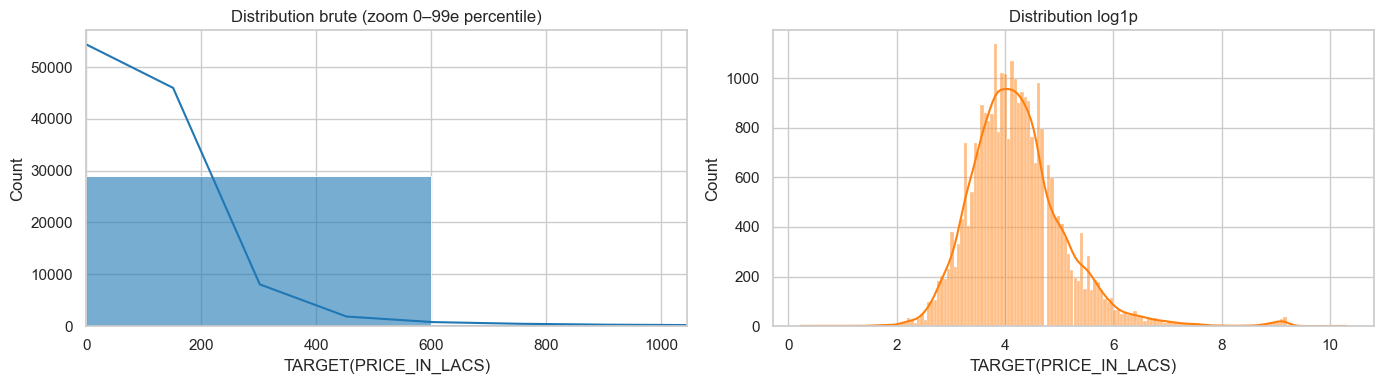

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Seuil au 99e percentile
q99 = train_df["TARGET(PRICE_IN_LACS)"].quantile(0.99)

sns.histplot(
    train_df["TARGET(PRICE_IN_LACS)"],
    kde=True,
    bins=50,
    ax=axes[0],
    color="#1f77b4",
    alpha=0.6
)


axes[0].set_xlim(0, q99)
axes[0].set_title("Distribution brute (zoom 0–99e percentile)")

sns.histplot(
    np.log1p(train_df["TARGET(PRICE_IN_LACS)"]),
    kde=True,
    ax=axes[1],
    color="#ff7f0e"
)
axes[1].set_title("Distribution log1p")

plt.tight_layout()
plt.show()


Corrélations (Pearson) avec la cible:
SQUARE_FT             0.402685
BHK_NO.               0.112283
RERA                  0.067636
UNDER_CONSTRUCTION    0.055399
LATITUDE             -0.017254
LONGITUDE            -0.031112
READY_TO_MOVE        -0.055399
RESALE               -0.207378
Name: TARGET(PRICE_IN_LACS), dtype: float64


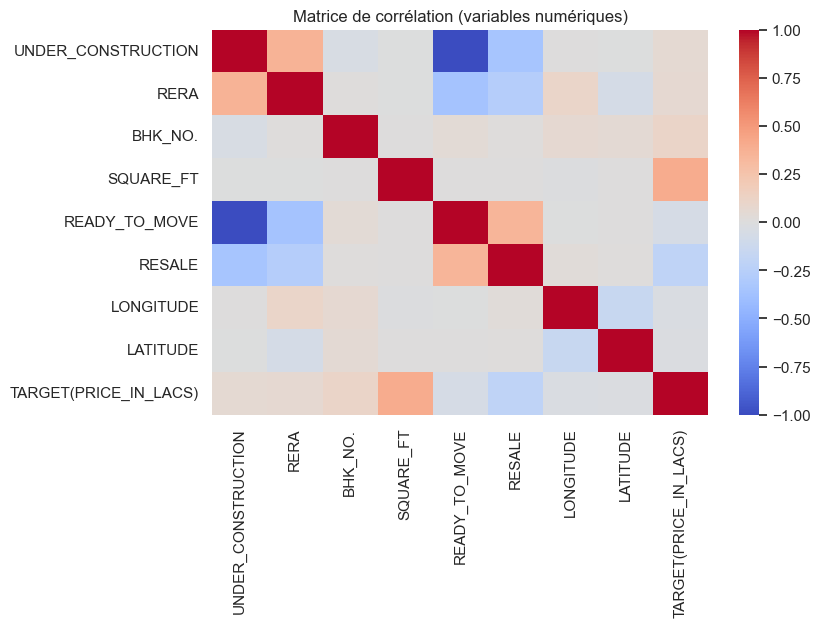

In [7]:
# Corrélations numériques avec la cible
num_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
if "TARGET(PRICE_IN_LACS)" in num_cols:
    num_cols_no_target = [c for c in num_cols if c != "TARGET(PRICE_IN_LACS)"]
else:
    num_cols_no_target = num_cols

corr_with_target = (
    train_df[num_cols_no_target + ["TARGET(PRICE_IN_LACS)"]]
    .corr(numeric_only=True)["TARGET(PRICE_IN_LACS)"]
    .drop("TARGET(PRICE_IN_LACS)")
    .sort_values(ascending=False)
)

print("Corrélations (Pearson) avec la cible:")
print(corr_with_target)

plt.figure(figsize=(8, 5))
sns.heatmap(
    train_df[num_cols_no_target + ["TARGET(PRICE_IN_LACS)"]].corr(numeric_only=True),
    cmap="coolwarm",
    center=0,
    annot=False
)
plt.title("Matrice de corrélation (variables numériques)")
plt.show()

In [8]:
# Cardinalité des variables catégorielles
cat_cols = train_df.select_dtypes(include=["object", "category"]).columns.tolist()
cardinality = train_df[cat_cols].nunique().sort_values(ascending=False)
print("Cardinalité des variables catégorielles:")
print(cardinality)

Cardinalité des variables catégorielles:
ADDRESS      6899
POSTED_BY       3
BHK_OR_RK       2
dtype: int64


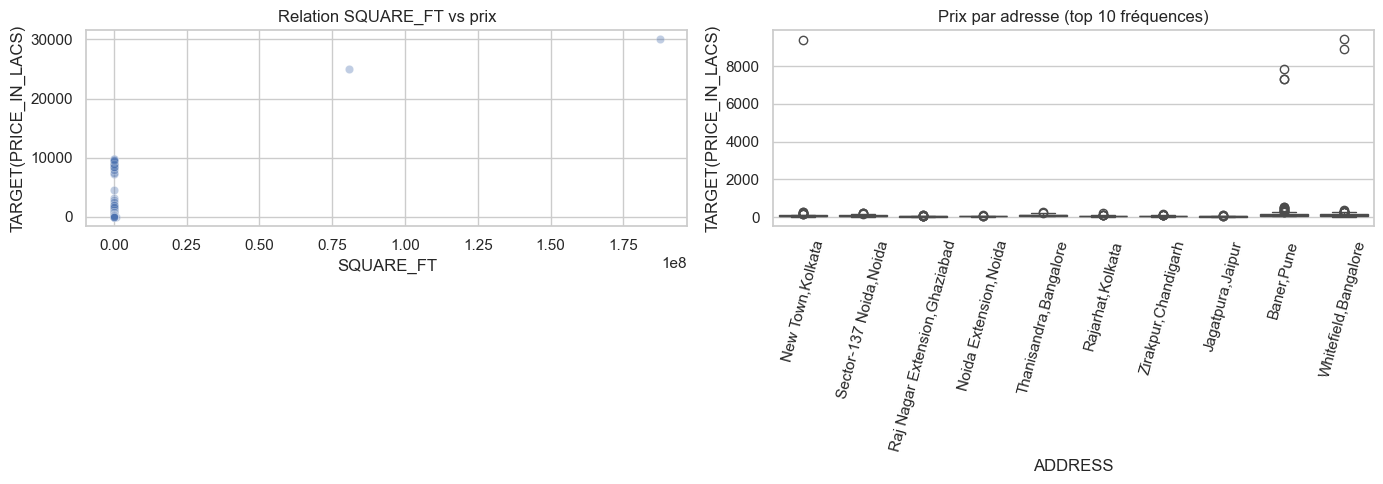

In [9]:
# Visualisations ciblées
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.scatterplot(
    data=train_df.sample(min(5000, len(train_df)), random_state=RANDOM_STATE),
    x="SQUARE_FT",
    y="TARGET(PRICE_IN_LACS)",
    alpha=0.35,
    ax=axes[0]
)
axes[0].set_title("Relation SQUARE_FT vs prix")

top_addr = train_df["ADDRESS"].value_counts().head(10).index
sns.boxplot(
    data=train_df[train_df["ADDRESS"].isin(top_addr)],
    x="ADDRESS",
    y="TARGET(PRICE_IN_LACS)",
    ax=axes[1]
)
axes[1].set_title("Prix par adresse (top 10 fréquences)")
axes[1].tick_params(axis="x", rotation=75)

plt.tight_layout()
plt.show()

### Décisions méthodologiques issues de l'EDA
- La cible est asymétrique: on évaluera notamment avec une métrique de type **RMSLE** (adaptée aux prix positifs).
- `ADDRESS` est très cardinale: pour éviter une explosion de dimension, on crée une variable `CITY` à partir de la partie après la dernière virgule.
- On conserve `ADDRESS` en plus de `CITY` dans un premier temps; la sélection sera tranchée empiriquement via la validation croisée.

In [10]:
# Feature engineering : extraction de CITY depuis ADDRESS
train_fe = train_df.copy()
test_fe = test_df.copy()

for df_ in (train_fe, test_fe):
    df_["CITY"] = (
        df_["ADDRESS"]
        .astype(str)
        .str.split(",")
        .str[-1]
        .str.strip()
    )

train_fe[["ADDRESS", "CITY"]].head()

,ADDRESS,CITY
0,"Ksfc Layout,Bangalore",Bangalore
1,"Vishweshwara Nagar,Mysore",Mysore
2,"Jigani,Bangalore",Bangalore
3,"Sector-1 Vaishali,Ghaziabad",Ghaziabad
4,"New Town,Kolkata",Kolkata


## 3) Séparation des données

Conformément aux bonnes pratiques, la séparation en **apprentissage** et **test de validation finale** est faite avant la phase de sélection d'hyperparamètres.

In [11]:
TARGET_COL = "TARGET(PRICE_IN_LACS)"

X = train_fe.drop(columns=[TARGET_COL])
y = train_fe[TARGET_COL].copy()

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.20,
    random_state=RANDOM_STATE
)

print("X_train:", X_train.shape, "| y_train:", y_train.shape)
print("X_valid:", X_valid.shape, "| y_valid:", y_valid.shape)

# Contrôles techniques de base
print("NaN y_train:", int(y_train.isna().sum()), "| NaN y_valid:", int(y_valid.isna().sum()))
print("Cible >= 0 :", bool((y >= 0).all()))

# Vérification anti-fuite: la cible n'est plus dans les features
assert TARGET_COL not in X_train.columns and TARGET_COL not in X_valid.columns, "Fuite: TARGET dans X"


X_train: (23560, 12) | y_train: (23560,)
X_valid: (5891, 12) | y_valid: (5891,)
NaN y_train: 0 | NaN y_valid: 0
Cible >= 0 : True


## 4) Modélisation et sélection des hyperparamètres (cross-validation)

### Modèles retenus
- **Ridge** (benchmark linéaire, non principal)
- **RandomForestRegressor** (modèle ensembliste)
- **ExtraTreesRegressor** (modèle ensembliste)
- **CatBoostRegressor** (boosting adapté aux variables catégorielles)

Les modèles principaux sont ensemblistes et on compare leurs performances via RMSLE en validation croisée.


In [12]:
# =========================
# Prétraitement commun
# =========================
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

numeric_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", min_frequency=50))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocess, numeric_features),
        ("cat", categorical_preprocess, categorical_features),
    ]
)

print("Nb variables numériques:", len(numeric_features))
print("Nb variables catégorielles:", len(categorical_features))


Nb variables numériques: 8
Nb variables catégorielles: 4


In [13]:
# =========================
# Métriques et validateurs
# =========================
def rmsle(y_true, y_pred):
    y_pred = np.maximum(y_pred, 0)
    return np.sqrt(np.mean((np.log1p(y_true) - np.log1p(y_pred)) ** 2))

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

cv_kfold = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
cv_repeated = RepeatedKFold(n_splits=3, n_repeats=2, random_state=RANDOM_STATE)

print("Validateur principal: KFold(3, shuffle=True)")
print("Validateur de robustesse: RepeatedKFold(3x2)")


Validateur principal: KFold(3, shuffle=True)
Validateur de robustesse: RepeatedKFold(3x2)


In [14]:
# =========================
# Pipelines et espaces de recherche
# =========================
models_and_search = {
    "Ridge_benchmark": {
        "pipeline": Pipeline(steps=[
            ("prep", preprocessor),
            ("model", Ridge(random_state=RANDOM_STATE))
        ]),
        "search_type": "grid",
        "param_grid": {
            "model__alpha": [0.1, 1.0, 10.0]
        }
    },
    "RandomForest": {
        "pipeline": Pipeline(steps=[
            ("prep", preprocessor),
            ("model", RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=1))
        ]),
        "search_type": "random",
        "param_distributions": {
            "model__n_estimators": [60, 100, 140],
            "model__max_depth": [10, 20],
            "model__min_samples_split": [2, 10],
            "model__min_samples_leaf": [1, 3],
            "model__max_features": ["sqrt"]
        },
        "n_iter": 6
    },
    "ExtraTrees": {
        "pipeline": Pipeline(steps=[
            ("prep", preprocessor),
            ("model", ExtraTreesRegressor(random_state=RANDOM_STATE, n_jobs=1))
        ]),
        "search_type": "grid",
        "param_grid": {
            "model__n_estimators": [80, 120],
            "model__max_depth": [10, 20],
            "model__min_samples_split": [2, 10],
            "model__min_samples_leaf": [1]
        }
    }
}


### CatBoost (natif sur variables catégorielles)
CatBoost est pertinent ici car il gère directement les variables catégorielles, sans OneHotEncoder, et capte des interactions non linéaires via boosting.
Cela réduit le risque de perte d'information liée à un encodage trop agressif de `ADDRESS`/`CITY`.
La métrique **RMSLE** pénalise les erreurs relatives en échelle logarithmique, ce qui est adapté aux prix fortement asymétriques.
Un RMSLE plus faible signifie des prédictions proportionnellement plus proches des prix observés.


In [15]:
from catboost import CatBoostRegressor

# CatBoost doit être entraîné sans passer par le preprocessing sklearn OHE.
assert "categorical_features" in globals(), "Il faut categorical_features défini depuis X_train"
assert isinstance(X_train, pd.DataFrame), "X_train doit rester un DataFrame pandas"
assert isinstance(X_valid, pd.DataFrame), "X_valid doit rester un DataFrame pandas"

catboost_model = CatBoostRegressor(
    loss_function="RMSE",
    random_seed=RANDOM_STATE,
    verbose=0,
    allow_writing_files=False
)

catboost_param_dist = {
    "depth": [4, 6, 8, 10],
    "learning_rate": [0.02, 0.03, 0.05, 0.1],
    "iterations": [400, 700, 1000, 1400],
    "l2_leaf_reg": [1, 3, 5, 7, 9],
    "subsample": [0.7, 0.85, 1.0],
    "bagging_temperature": [0.0, 0.5, 1.0],
}

models_and_search["CatBoost"] = {
    "native_catboost": True,
    "estimator": catboost_model,
    "search_type": "random",
    "param_distributions": catboost_param_dist,
    "n_iter": 20,
}

print("CatBoost ajouté à la recherche d'hyperparamètres (RandomizedSearchCV).")


CatBoost ajouté à la recherche d'hyperparamètres (RandomizedSearchCV).


In [16]:
print("CatBoost utilisera cat_features=categorical_features lors du fit CV.")


CatBoost utilisera cat_features=categorical_features lors du fit CV.


In [17]:
# =========================
# Recherche d'hyperparamètres
# - GridSearchCV / RandomizedSearchCV pour modèles sklearn
# - RandomizedSearchCV + cat_features pour CatBoost
# =========================
search_results = []
best_estimators = {}

for model_name, cfg in models_and_search.items():
    print(f"===== {model_name} =====")

    if cfg.get("native_catboost", False):
        search = RandomizedSearchCV(
            estimator=cfg["estimator"],
            param_distributions=cfg["param_distributions"],
            n_iter=cfg.get("n_iter", 20),
            scoring=rmsle_scorer,
            cv=cv_kfold,
            n_jobs=1,
            random_state=RANDOM_STATE,
            verbose=0,
            refit=True,
            error_score="raise",
            return_train_score=True,
        )
        search.fit(X_train, y_train, cat_features=categorical_features)

    elif cfg["search_type"] == "random":
        search = RandomizedSearchCV(
            estimator=cfg["pipeline"],
            param_distributions=cfg["param_distributions"],
            n_iter=cfg.get("n_iter", 24),
            scoring=rmsle_scorer,
            cv=cv_kfold,
            n_jobs=1,
            random_state=RANDOM_STATE,
            verbose=0,
            refit=True,
            error_score="raise",
            return_train_score=True,
        )
        search.fit(X_train, y_train)

    else:
        search = GridSearchCV(
            estimator=cfg["pipeline"],
            param_grid=cfg["param_grid"],
            scoring=rmsle_scorer,
            cv=cv_kfold,
            n_jobs=1,
            verbose=0,
            refit=True,
            error_score="raise",
            return_train_score=True,
        )
        search.fit(X_train, y_train)

    best_estimators[model_name] = search.best_estimator_
    search_results.append({
        "model": model_name,
        "best_params": search.best_params_,
        "cv_rmsle": -search.best_score_,
    })

    if model_name == "CatBoost":
        print("CatBoost best params:", search.best_params_)
        print("CatBoost best CV RMSLE:", round(-search.best_score_, 5))
    else:
        print("Best params:", search.best_params_)
        print("Best CV RMSLE:", round(-search.best_score_, 5))

results_df = pd.DataFrame(search_results).sort_values("cv_rmsle", ascending=True).reset_index(drop=True)
results_df


===== Ridge_benchmark =====


Best params: {'model__alpha': 10.0}
Best CV RMSLE: 1.60555
===== RandomForest =====


Best params: {'model__n_estimators': 100, 'model__min_samples_split': 10, 'model__min_samples_leaf': 1, 'model__max_features': 'sqrt', 'model__max_depth': 20}
Best CV RMSLE: 0.47226
===== ExtraTrees =====


Best params: {'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 120}
Best CV RMSLE: 0.38099
===== CatBoost =====


CatBoost best params: {'subsample': 1.0, 'learning_rate': 0.03, 'l2_leaf_reg': 1, 'iterations': 400, 'depth': 10, 'bagging_temperature': 0.5}
CatBoost best CV RMSLE: 0.35683


,model,best_params,cv_rmsle
0,CatBoost,"{'subsample': 1.0, 'learning_rate': 0.03, 'l2_...",0.356833
1,ExtraTrees,"{'model__max_depth': 20, 'model__min_samples_l...",0.380994
2,RandomForest,"{'model__n_estimators': 100, 'model__min_sampl...",0.472264
3,Ridge_benchmark,{'model__alpha': 10.0},1.605549


In [18]:
# Vérification de robustesse sur le meilleur modèle CV (RepeatedKFold)
best_model_name = results_df.iloc[0]["model"]
best_model = best_estimators[best_model_name]

if best_model_name == "CatBoost":
    robust_scores_list = []
    for tr_idx, va_idx in cv_repeated.split(X_train, y_train):
        X_tr_fold = X_train.iloc[tr_idx]
        y_tr_fold = y_train.iloc[tr_idx]
        X_va_fold = X_train.iloc[va_idx]
        y_va_fold = y_train.iloc[va_idx]

        fold_model = clone(best_model)
        fold_model.fit(X_tr_fold, y_tr_fold, cat_features=categorical_features)
        fold_pred = fold_model.predict(X_va_fold)
        robust_scores_list.append(rmsle(y_va_fold, fold_pred))

    robust_scores = np.array(robust_scores_list)
else:
    robust_scores = -cross_val_score(
        best_model,
        X_train,
        y_train,
        scoring=rmsle_scorer,
        cv=cv_repeated,
        n_jobs=1
    )

print("Meilleur modèle (KFold):", best_model_name)
print("RMSLE moyen (RepeatedKFold):", round(robust_scores.mean(), 5))
print("RMSLE écart-type:", round(robust_scores.std(), 5))


Meilleur modèle (KFold): CatBoost
RMSLE moyen (RepeatedKFold): 0.36038
RMSLE écart-type: 0.01001


## 5) Évaluation finale et discussion

On fige le meilleur modèle selon la validation croisée, puis on évalue ses performances sur l'ensemble de validation final (`X_valid`, `y_valid`).

> La matrice de confusion n'est **pas applicable** ici car il s'agit d'une **régression** (et non d'une classification).

In [19]:
# =========================
# Évaluation finale du meilleur modèle
# =========================
def regression_metrics(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred),
        "RMSLE": rmsle(y_true, y_pred),
    }

if best_model_name == "CatBoost":
    best_model.fit(X_train, y_train, cat_features=categorical_features)
else:
    best_model.fit(X_train, y_train)

pred_train = best_model.predict(X_train)
pred_valid = best_model.predict(X_valid)

train_metrics = regression_metrics(y_train, pred_train)
valid_metrics = regression_metrics(y_valid, pred_valid)

metrics_df = pd.DataFrame([train_metrics, valid_metrics], index=["Train", "Validation"]).T
metrics_df


,Train,Validation
MAE,25.602913,37.430312
RMSE,97.954820,356.454033
R2,0.976198,0.766806
RMSLE,0.312111,0.345536


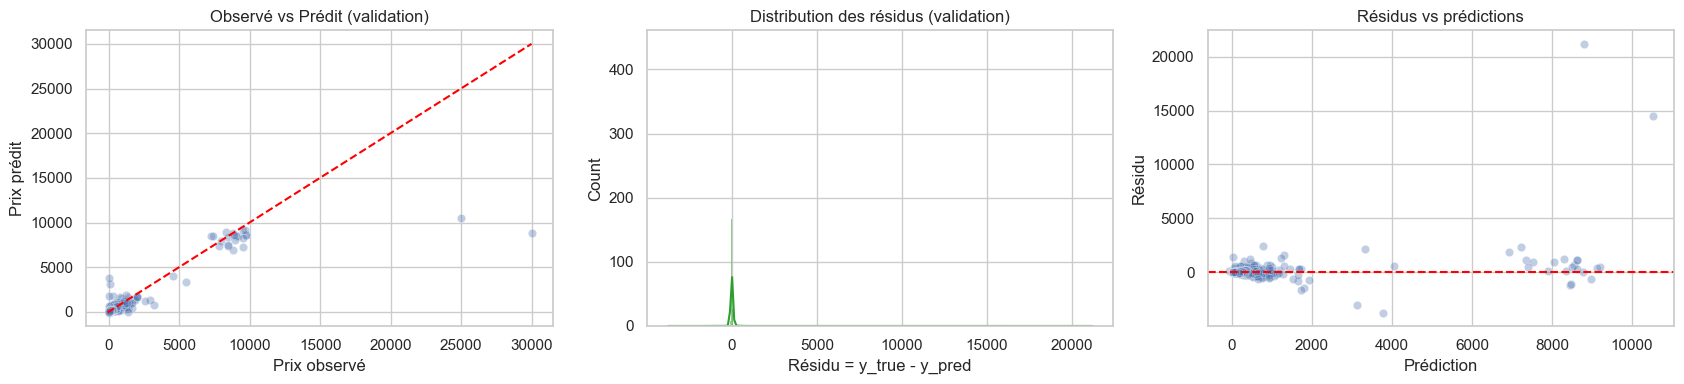

In [20]:
# Visualisations d'évaluation
residuals = y_valid - pred_valid

fig, axes = plt.subplots(1, 3, figsize=(17, 4))

sns.scatterplot(x=y_valid, y=pred_valid, alpha=0.35, ax=axes[0])
min_v = min(y_valid.min(), pred_valid.min())
max_v = max(y_valid.max(), pred_valid.max())
axes[0].plot([min_v, max_v], [min_v, max_v], color="red", linestyle="--")
axes[0].set_title("Observé vs Prédit (validation)")
axes[0].set_xlabel("Prix observé")
axes[0].set_ylabel("Prix prédit")

sns.histplot(residuals, kde=True, ax=axes[1], color="#2ca02c")
axes[1].set_title("Distribution des résidus (validation)")
axes[1].set_xlabel("Résidu = y_true - y_pred")

sns.scatterplot(x=pred_valid, y=residuals, alpha=0.35, ax=axes[2])
axes[2].axhline(0, color="red", linestyle="--")
axes[2].set_title("Résidus vs prédictions")
axes[2].set_xlabel("Prédiction")
axes[2].set_ylabel("Résidu")

plt.tight_layout()
plt.show()

## 6) Analyse des résultats

Les résultats de validation croisée et de validation finale convergent vers la même hiérarchie: **CatBoost** > **ExtraTrees** > **RandomForest** >> **Ridge**.
Le tableau comparatif indique:
- CatBoost: `cv_rmsle = 0.356833`, `train_rmsle = 0.312111`, `valid_rmsle = 0.345536`, `gap = 0.033425`
- ExtraTrees: `cv_rmsle = 0.380994`, `train_rmsle = 0.276004`, `valid_rmsle = 0.375344`, `gap = 0.099339`
- RandomForest: `cv_rmsle = 0.472264`, `train_rmsle = 0.436854`, `valid_rmsle = 0.479078`, `gap = 0.042224`
- Ridge: `cv_rmsle = 1.605549`, `train_rmsle = 1.537765`, `valid_rmsle = 1.575655`, `gap = 0.037890`

Le meilleur modèle est donc objectivement **CatBoost**, à la fois sur le score CV et sur le score de validation.
Cette cohérence réduit le risque d'un choix biaisé par un split particulier.

Sur le plan de la stabilité, la validation répétée du meilleur modèle donne `RMSLE moyen = 0.36038` et `écart-type = 0.01001`.
Un écart-type de cet ordre suggère une variabilité modérée des performances selon les folds, compatible avec une bonne robustesse pratique.

Interprétation de RMSLE: cette métrique opère en échelle logarithmique et mesure une erreur relative multiplicative.
À titre indicatif, un RMSLE `r` correspond approximativement à une erreur relative typique de `exp(r)-1`.
Ainsi, `r = 0.345536` (CatBoost) suggère un ordre de grandeur d'erreur relative d'environ 41%, contre environ 46% (ExtraTrees), 61% (RandomForest) et bien davantage pour Ridge.
Cette lecture reste indicative, mais elle permet de comparer les modèles sur une base directement interprétable en proportion d'erreur.


In [21]:
# Tableau comparatif (modèle, best_params, score CV, score validation)
comparison_rows = []

for model_name, model in best_estimators.items():
    if model_name == "CatBoost":
        model.fit(X_train, y_train, cat_features=categorical_features)
    else:
        model.fit(X_train, y_train)

    pred_tr = model.predict(X_train)
    pred_va = model.predict(X_valid)

    train_rmsle = rmsle(y_train, pred_tr)
    valid_rmsle = rmsle(y_valid, pred_va)

    comparison_rows.append({
        "model": model_name,
        "train_rmsle": train_rmsle,
        "valid_rmsle": valid_rmsle,
        "gap_rmsle": valid_rmsle - train_rmsle,
    })

comparison_df = pd.DataFrame(comparison_rows)
comparison_df = comparison_df.merge(results_df[["model", "cv_rmsle", "best_params"]], on="model", how="left")
comparison_df = comparison_df[["model", "best_params", "cv_rmsle", "train_rmsle", "valid_rmsle", "gap_rmsle"]]
comparison_df = comparison_df.sort_values("valid_rmsle", ascending=True).reset_index(drop=True)

# Contrôles finaux de validité numérique
assert np.isfinite(comparison_df[["cv_rmsle", "train_rmsle", "valid_rmsle", "gap_rmsle"]].to_numpy()).all(), "Valeurs non finies détectées"
assert not comparison_df[["cv_rmsle", "train_rmsle", "valid_rmsle", "gap_rmsle"]].isna().any().any(), "NaN détecté"

comparison_df


,model,best_params,cv_rmsle,train_rmsle,valid_rmsle,gap_rmsle
0,CatBoost,"{'subsample': 1.0, 'learning_rate': 0.03, 'l2_...",0.356833,0.312111,0.345536,0.033425
1,ExtraTrees,"{'model__max_depth': 20, 'model__min_samples_l...",0.380994,0.276004,0.375344,0.099339
2,RandomForest,"{'model__n_estimators': 100, 'model__min_sampl...",0.472264,0.436854,0.479078,0.042224
3,Ridge_benchmark,{'model__alpha': 10.0},1.605549,1.537765,1.575655,0.037890


### Discussion critique des modèles

Les modèles ensemblistes surpassent nettement la régression linéaire Ridge, ce qui est cohérent avec la structure du problème.
Le prix immobilier dépend d'interactions non linéaires entre surface, localisation, état du bien, et variables catégorielles à forte cardinalité (`ADDRESS`, `CITY`).
Un modèle linéaire additif est trop contraint pour représenter cette complexité, d'où sa contre-performance marquée.

Parmi les approches ensemblistes, **CatBoost** obtient le meilleur compromis biais/variance.
Son `gap` train-validation (`0.033425`) est plus faible que celui d'ExtraTrees (`0.099339`), tout en conservant la meilleure performance absolue sur validation (`valid_rmsle = 0.345536`).
ExtraTrees atteint un excellent score, mais l'écart train-validation plus élevé indique un sur-apprentissage plus prononcé.
RandomForest est plus conservateur (gap intermédiaire), mais reste moins précis.

La performance spécifique de CatBoost est plausible méthodologiquement: le modèle exploite nativement les variables catégorielles sans encodage one-hot explicite et apprend des interactions complexes par boosting.
Dans ce contexte tabulaire mixte (numérique + catégoriel), cette propriété constitue un avantage structurel par rapport aux pipelines classiques fondés sur OHE.

Limites de l'étude:
- présence probable d'observations extrêmes (outliers) qui dégradent RMSE et la qualité locale des prédictions;
- description géographique simplifiée (`LONGITUDE`, `LATITUDE`, extraction rudimentaire de `CITY`), sans variables de distance ou voisinage;
- feature engineering volontairement limité (pas d'interactions spatiales avancées, pas de segmentation explicite du marché);
- tuning réalisé avec un budget de recherche contrôlé, donc potentiellement sous-optimal pour certains modèles.

En conséquence, les résultats sont solides pour une première baseline avancée, mais ils ne doivent pas être interprétés comme une borne de performance définitive.


## Annexe - Prédictions sur le fichier test 
Cette partie est utile pour générer un fichier compatible challenge, mais n'est pas obligatoire pour l'évaluation académique.

In [22]:
# Entraînement final sur tout le train puis prédiction sur test
final_model = best_estimators[best_model_name]

if best_model_name == "CatBoost":
    final_model.fit(X, y, cat_features=categorical_features)
else:
    final_model.fit(X, y)

test_predictions = final_model.predict(test_fe)
test_predictions = np.maximum(test_predictions, 0)

submission = pd.DataFrame({"TARGET(PRICE_IN_LACS)": test_predictions})
submission_path = "submission_best_model.csv"
submission.to_csv(submission_path, index=False)

print("Fichier de soumission généré:", submission_path)
submission.head()


Fichier de soumission généré: submission_best_model.csv


,TARGET(PRICE_IN_LACS)
0,17.369913
1,49.176686
2,62.912424
3,46.947175
4,16.119098


## Conclusion

Ce travail a suivi une démarche complète et reproductible: exploration descriptive des données, définition d'un prétraitement adapté aux variables mixtes, séparation apprentissage/validation, sélection d'hyperparamètres par validation croisée, puis évaluation finale sur un jeu tenu à l'écart.

L'analyse comparative identifie **CatBoost** comme modèle final, avec les meilleurs scores observés (`cv_rmsle = 0.356833`, `valid_rmsle = 0.345536`) et une stabilité satisfaisante en validation répétée (`0.36038 ± 0.01001`).
Le choix final est donc justifié à la fois par la performance et par la robustesse, et non par un seul indicateur isolé.

D'un point de vue méthodologique, l'écart de performance entre Ridge et les modèles ensemblistes confirme que la relation entre variables explicatives et prix est fortement non linéaire, avec des interactions importantes et un rôle majeur des variables catégorielles.

Des améliorations réalistes pour une itération suivante sont:
1. Enrichir le feature engineering (distances à des centres urbains, interactions surface x localisation, variables de densité/voisinage).
2. Tester des méta-modèles de type stacking/blending pour combiner les biais complémentaires de CatBoost, ExtraTrees et RandomForest.
3. Étendre le protocole de validation et de tuning (plus de folds, budget de recherche plus large, analyse par segments de prix) afin d'affiner la généralisation.

En synthèse, l'objectif de prédiction est atteint avec un modèle final cohérent, performant et argumenté.
